In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("drive/My Drive/Colab Notebooks")

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ELU
from torch.optim import Adam, SGD

In [0]:
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
device

device(type='cuda')

In [0]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [7]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [8]:
# create labels 
y_train_valid = y_train_valid - 769
y_test = y_test -769

person_train_valid = person_train_valid.squeeze()


# split training and validation
X_train, X_val, y_train, y_val, person_train, person_val = train_test_split(X_train_valid, y_train_valid, person_train_valid, test_size = 0.1)
data = []
(X_train.shape, y_train.shape, person_train.shape), (X_val.shape, y_val.shape, person_val.shape)

(((1903, 22, 1000), (1903,), (1903,)), ((212, 22, 1000), (212,), (212,)))

In [0]:
# transform to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)


In [0]:
# class Net(Module):
#     def __init__(self):
#         super(Net, self).__init__()

#         self.ave = nn.AvgPool1d(kernel_size = 10, stride = 10)
#         # 22*100
#         self.cnn_layers = Sequential(
#             # first conv
#             nn.Conv1d(in_channels = 22, out_channels = 32, kernel_size = 3, stride=1),
#             #32*98
#             nn.BatchNorm1d(32),
#             nn.ELU(inplace=True),
#             nn.MaxPool1d(kernel_size=4, stride=2),
#             #32*48

#             # second conv
#             nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, stride=1),
#             # 64*46
#             nn.BatchNorm1d(64),
#             nn.ELU(inplace=True),
#             nn.MaxPool1d(kernel_size=4, stride=2),
#             # output 64*22

#             # third conv
#             # nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 3, stride=1),
#             # # 64*20
#             # nn.BatchNorm1d(64),
#             # nn.ELU(inplace=True),
#             # nn.MaxPool1d(kernel_size=4, stride=2),
#             # # 64*9
#         )

#         self.lstm= nn.LSTM(64, 16, 4, batch_first=True, dropout = 0.1, bidirectional = True)

#         # 64
#         self.linear_layers = Sequential(
#             Linear(22*32,128),
#             nn.BatchNorm1d(128),
#             ReLU(inplace=True),

#             Linear(128,32),
#             nn.BatchNorm1d(32),
#             ReLU(inplace=True),

#             Linear(32, 4)
#         )
        
#     def forward(self, x):
#         x = self.ave(x)
#         x = self.cnn_layers(x)
#         x = x.transpose(1, 2)
#         x,_ = self.lstm(x)
#         x = x.reshape((-1, 22*32))
#         x = self.linear_layers(x)
#         return x
        

In [0]:
# reduce maxpooling layers
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()

        self.ave = nn.AvgPool1d(kernel_size = 10, stride = 10)
        # 22*100
        self.cnn_layers = Sequential(
            # first conv
            nn.Conv1d(in_channels = 22, out_channels = 32, kernel_size = 3, stride=1),
            nn.BatchNorm1d(32),
            nn.ELU(inplace=True),

            # second conv
            nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = 3, stride=1),
            nn.BatchNorm1d(32),
            nn.ELU(inplace=True),

            # third conv
            nn.Conv1d(in_channels = 32, out_channels = 32, kernel_size = 3, stride=1),
            nn.BatchNorm1d(32),
            nn.ELU(inplace=True),
            nn.MaxPool1d(kernel_size=4, stride=2),
            # 64*46
        )

        self.lstm= nn.LSTM(32, 16, 4, batch_first=True, dropout = 0.1, bidirectional = True)

        self.linear_layers = Sequential(
            Linear(46*32,128),
            nn.BatchNorm1d(128),
            ReLU(inplace=True),

            Linear(128,32),
            nn.BatchNorm1d(32),
            ReLU(inplace=True),

            Linear(32, 4)
        )
        
    def forward(self, x):
        x = self.ave(x)
        x = self.cnn_layers(x)
        x = x.transpose(1, 2)
        x,_ = self.lstm(x)
        x = x.reshape((-1, 46*32))
        x = self.linear_layers(x)
        return x
        

In [0]:
# class Net(Module):
#     def __init__(self):
#         super(Net, self).__init__()

#         self.ave = nn.AvgPool1d(kernel_size = 10, stride = 10)
#         # 22*50
#         self.fc1 = Linear(22, 10)
#         # 50*7
#         self.lstm= nn.LSTM(10, 64, 4, batch_first=True, dropout = 0)

#         # 64
#         self.linear_layers = Sequential(
#             Linear(64*100,128),
#             nn.BatchNorm1d(128),
#             ReLU(inplace=True),

#             Linear(128,32),
#             nn.BatchNorm1d(32),
#             ReLU(inplace=True),

#             Linear(32, 4)
#         )
        
#     def forward(self, x):
#         x = self.ave(x)
#         x = x.transpose(1, 2)
#         x = self.fc1(x)
#         x,_ = self.lstm(x)
#         # x = x[:, -1, :]
#         # x = self.linear_layers(x.squeeze())
#         x = x.reshape((-1, 64*100))
#         x = self.linear_layers(x)
#         return x
        

In [11]:
# defining the model
model = Net()
model = model.float()

# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (ave): AvgPool1d(kernel_size=(10,), stride=(10,), padding=(0,))
  (cnn_layers): Sequential(
    (0): Conv1d(22, 32, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0, inplace=True)
    (9): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(32, 16, num_layers=4, batch_first=True, dropout=0.1, bidirectional=True)
  (linear_layers): Sequential(
    (0): Linear(in_features=1472, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [12]:
model = Net()
model = model.float()
#torch.manual_seed(2)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
##### hyperparameters#########
batch_size = 10
lrs = [1e-3]
weight_decay = 0 # regularization
optimizer = Adam(model.parameters(), lr=lrs[0],  weight_decay=weight_decay)
n_epochs = 20
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for lr in lrs:
    optimizer = Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
    for epoch in range(n_epochs):
        train_loss = 0

        for i,data in enumerate(train_loader, 0):
            # extract data in this batch
            inputs, labels = data

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            output = model(inputs.float())
            loss_train = criterion(output, labels.long())
            loss_train.backward()
            optimizer.step()

            #Print statistics
            train_loss += loss_train
   
        ## training accuracy
        with torch.no_grad():
            output = model(X_train.cuda().float())
            
        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob, axis=1)
        # accuracy on training set
        train_acc = accuracy_score(y_train.cpu(), predictions)

        # validation loss
        with torch.no_grad():
            output = model(X_val.cuda().float())
        val_loss = criterion(output, y_val.cuda().long())
        
        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob, axis=1)
        # accuracy on validation set
        val_acc = accuracy_score(y_val.cpu(), predictions)

        ## test accuracy
        with torch.no_grad():
            output = model(X_test.to(device).cuda().float())
        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob, axis=1)

        # accuracy on test set
        test_acc = accuracy_score(y_test.cpu(), predictions)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print("Epoch {}, train_loss: {:.2f}, \t val_loss: {:.2f} ".format(
                    epoch+1, train_loss, val_loss))
        print("training accuracy = {:.2f}, \t validation accuracy = {:.2f}, \t test accuracy = {:.2f}".format(train_acc, val_acc, test_acc))

Epoch 1, train_loss: 254.71, 	 val_loss: 1.28 
training accuracy = 0.46, 	 validation accuracy = 0.41, 	 test accuracy = 0.39
Epoch 2, train_loss: 235.26, 	 val_loss: 1.21 
training accuracy = 0.51, 	 validation accuracy = 0.46, 	 test accuracy = 0.45
Epoch 3, train_loss: 225.41, 	 val_loss: 1.20 
training accuracy = 0.55, 	 validation accuracy = 0.44, 	 test accuracy = 0.48
Epoch 4, train_loss: 212.28, 	 val_loss: 1.12 
training accuracy = 0.59, 	 validation accuracy = 0.52, 	 test accuracy = 0.52
Epoch 5, train_loss: 199.52, 	 val_loss: 1.09 
training accuracy = 0.65, 	 validation accuracy = 0.55, 	 test accuracy = 0.53
Epoch 6, train_loss: 187.63, 	 val_loss: 1.03 
training accuracy = 0.70, 	 validation accuracy = 0.52, 	 test accuracy = 0.58
Epoch 7, train_loss: 181.46, 	 val_loss: 0.98 
training accuracy = 0.73, 	 validation accuracy = 0.60, 	 test accuracy = 0.58
Epoch 8, train_loss: 167.77, 	 val_loss: 1.01 
training accuracy = 0.72, 	 validation accuracy = 0.56, 	 test accuracy

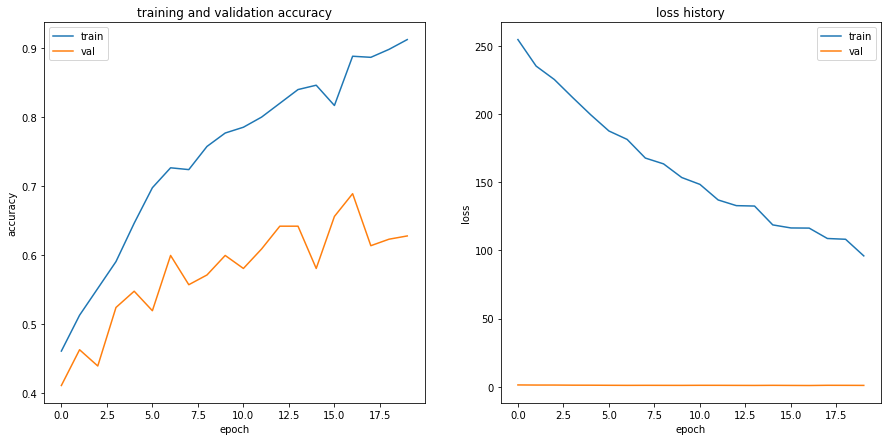

In [13]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.subplot(1, 2, 2)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])